In [20]:
##nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build


# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# !pip install category_encoders
# !pip install xgboost
!pip install lightgbm --user
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

# Descriptive statistics

In [151]:
date_train = '2021-06-01'
date_eval = '2021-07-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_0922.csv')
df= df_raw.copy()
df['effective_start_date'] = pd.to_datetime(df['effective_start_date'])
df = df[df['effective_start_date']<=date_eval]

display(df.head(2))
print(df.isnull().sum())
display(df.describe())


grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date']
df = df[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
df['start_year'] = pd.to_datetime(df['effective_start_date']).dt.year
df['start_month'] = pd.to_datetime(df['effective_start_date']).dt.month
df['start_year_month'] = df['effective_start_date'].dt.strftime('%Y-%m')
df['start_quarter'] = df['effective_start_date'].dt.quarter

print(df.shape)
display(df.describe())
print('# title: ', df.title_name.nunique())
df = df[df['first_views']!=0]
print(df.shape)
df['first_views_log'] = np.log10(df['first_views'])

,Unnamed: 0,title_id,title_name,season_number,content_category,content_source,program_type,category,tier,effective_start_date,request_date,premiere_ind,asset_premiere_count,premiering_hours_runtime,first_views,hours_viewed,days_since_premiere,days_on_platform,finished_window_flag
0,0,GX6qNfA264sPCwgEAAAAD,Baby God,0,movies,HBO,original,Documentary Features,3,2020-12-03,2021-01-09,0,0,0.0,15,1781.141,37,291,1
1,1,GX6qNfA264sPCwgEAAAAD,Baby God,0,movies,HBO,original,Documentary Features,3,2020-12-03,2021-01-10,0,0,0.0,17,2138.678,38,291,1


Unnamed: 0                  0
title_id                    0
title_name                  0
season_number               0
content_category            0
content_source              0
program_type                0
category                    0
tier                        0
effective_start_date        0
request_date                0
premiere_ind                0
asset_premiere_count        0
premiering_hours_runtime    0
first_views                 0
hours_viewed                0
days_since_premiere         0
days_on_platform            0
finished_window_flag        0
dtype: int64


,Unnamed: 0,season_number,tier,premiere_ind,asset_premiere_count,premiering_hours_runtime,first_views,hours_viewed,days_since_premiere,days_on_platform,finished_window_flag
count,24952.000000,24952.000000,24952.000000,24952.000000,24952.000000,24952.000000,24952.000000,2.495200e+04,24952.000000,24952.000000,24952.000000
mean,14219.405779,3.161710,2.606805,0.011302,0.066167,0.034053,735.776691,2.915969e+04,44.597948,299.374078,0.978118
std,8618.461170,9.670572,0.619166,0.105709,0.882313,0.323366,8215.019659,1.945573e+05,26.328659,109.667296,0.146301
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,81.000000,0.000000
25%,6328.750000,0.000000,2.000000,0.000000,0.000000,0.000000,5.000000,6.153547e+02,22.000000,221.000000,1.000000
50%,14186.500000,1.000000,3.000000,0.000000,0.000000,0.000000,30.000000,3.159943e+03,44.000000,312.000000,1.000000
75%,21602.250000,1.000000,3.000000,0.000000,0.000000,0.000000,188.000000,1.269559e+04,67.000000,389.000000,1.000000
max,28934.000000,51.000000,3.000000,1.000000,35.000000,15.436000,732742.000000,9.817929e+06,90.000000,481.000000,1.000000


(282, 14)


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter
count,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,282.000000
mean,2.588652,3.078014,6.510319e+04,3.013089,2020.354610,7.131206,2.691489
std,0.632128,9.565709,2.438481e+05,2.446509,0.479245,3.366226,1.100242
min,1.000000,0.000000,1.200000e+01,0.000000,2020.000000,1.000000,1.000000
25%,2.000000,0.000000,1.304250e+03,1.439000,2020.000000,5.000000,2.000000
50%,3.000000,1.000000,5.736000e+03,1.980000,2020.000000,7.000000,3.000000
75%,3.000000,1.000000,2.803425e+04,4.542750,2021.000000,10.000000,4.000000
max,3.000000,51.000000,2.727097e+06,15.436000,2021.000000,12.000000,4.000000


# title:  238
(282, 14)


In [152]:
## add imdb features 
df_imdb = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered.csv')
print(df_imdb.columns)

col = ['title_id', 'asset_title_long', 'imdb_id', 'genres', 'title_type',
       'ref_follows', 'ref_remake_of', 'ref_spin_off_from',
      'ref_ref_featured_in','ref_ref_spoofed_in']

df = df.merge(df_imdb[col], how='left', on=['title_id'])
df['ref_tot'] = df[['ref_follows','ref_remake_of','ref_spin_off_from']].sum(axis=1)
df['ref_ref_tot'] = df[['ref_ref_featured_in','ref_ref_spoofed_in']].sum(axis=1)

df = df.fillna(0)
df.head(2)
print(df.shape)
print('# title: ', df.title_name.nunique())
print(df.isnull().sum())

Index(['Unnamed: 0', 'tier', 'content_category', 'category', 'title_name',
       'title_id', 'season_number', 'program_type', 'first_views',
       'title_type', 'imdb_id', 'asset_title_long', 'genres', 'ref_follows',
       'ref_spin_off_from', 'ref_remake_of', 'ref_ref_featured_in',
       'ref_ref_spoofed_in'],
      dtype='object')
(583, 26)
# title:  238
tier                        0
content_category            0
category                    0
title_name                  0
title_id                    0
season_number               0
program_type                0
effective_start_date        0
first_views                 0
premiering_hours_runtime    0
start_year                  0
start_month                 0
start_year_month            0
start_quarter               0
first_views_log             0
asset_title_long            0
imdb_id                     0
genres                      0
title_type                  0
ref_follows                 0
ref_remake_of               0
ref_spi

In [160]:
# data availability 
df.groupby(by=['start_year','start_month','tier']).agg({'title_id':'count'})

title_id
start_year start_month tier          
2020       5           1            3
                       3            5
           6           1            3
                       2            8
                       3           11
           7           2            3
                       3           12
           8           1            1
                       2            5
                       3           22
           9           1            1
                       2            3
                       3           15
           10          1            2
                       2            2
                       3           20
           11          1            1
                       2           22
                       3           20
           12          1            2
                       2            4
                       3           17
2021       1           1            1
                       2            4
                       3           14
           2           2            6
                       3           10
           3           1            2
                       2            3
                       3           10
           4           1            3
                       2            2
                       3           12
           5           1            3
                       2            4
                       3            8
           6           2            3
                       3           12
           7           2            3

,first_views
count,2.810000e+02
mean,6.532421e+04
std,2.442548e+05
min,1.200000e+01
1%,2.100000e+01
5%,1.050000e+02
10%,3.350000e+02
25%,1.285000e+03
50%,5.800000e+03
75%,2.835400e+04


title_id first_views                              \
                       nunique         sum       mean       std    min   
tier content_category                                                    
1    movies                  6     7612474  1087496.0  999907.0  43052   
     series                 10     1747840   174784.0  148085.0   6203   
     special                 4     1390145   347536.0  378901.0  25780   
2    movies                 26     3583165   127970.0  179821.0   1234   
     series                 24     1881420    47036.0  120723.0     21   
     special                 4      192115    48029.0   52532.0  11903   
3    movies                 76     1094649    14403.0   45783.0     12   
     series                 76      833511     8419.0   15606.0     15   
     special                13       20783     1599.0    1602.0    236   

                                                                           \
                           q10       q25        q50        q75        q90   
tier content_category                                                       
1    movies            59660.0  297628.0  1074951.0  1586059.0  2301136.0   
     series            23046.0   58491.0   141230.0   280893.0   366262.0   
     special           51843.0   90938.0   248280.0   504878.0   722634.0   
2    movies            20234.0   32638.0    49927.0   122083.0   395115.0   
     series              310.0     958.0     8336.0    55145.0    86187.0   
     special           16005.0   22158.0    27070.0    52940.0    96819.0   
3    movies              416.0    1642.0     4765.0    12766.0    19394.0   
     series              187.0     947.0     2632.0     9020.0    19453.0   
     special             262.0     658.0      784.0     1934.0     3735.0   

                                
                           max  
tier content_category           
1    movies            2727097  
     series             420643  
     special            867805  
2    movies             635584  
     series             758825  
     special            126072  
3    movies             352452  
     series              99113  
     special              5432

title_id first_views             \
                                              nunique         sum       mean   
tier content_category category                                                 
1    movies           Pay1                          2      113784    56892.0   
                      Popcorn                       3     5819210  1939737.0   
                      Scripted Features             2     1679480   839740.0   
     series           Kids & Family                 3      163339    54446.0   
                      Scripted Comedy Series        1      242337   242337.0   
                      Scripted Drama Series         6     1342164   223694.0   
     special          Specials                      4     1390145   347536.0   
2    movies           Documentary Features          2       81525    40762.0   
                      Pay1                         11      470989    42817.0   
                      Popcorn                       6     2470510   411752.0   
                      Scripted Features             7      553412    79059.0   
                      Specials                      1        1234     1234.0   
                      Unscripted Series             1        5495     5495.0   
     series           Docu-Series                   7      349855    49979.0   
                      Documentary Features          1      108619   108619.0   
                      Kids & Family                 2       33894     2118.0   
                      Scripted Comedy Series        3      134680    33670.0   
                      Scripted Drama Series         5     1014846   202969.0   
                      Unscripted Series             6      239526    34218.0   
     special          Specials                      4      192115    48029.0   
3    movies           Documentary Features         36      347851     9663.0   
                      International                 6        3283      547.0   
                      Pay1                         28      373222    13329.0   
                      Scripted Features             2      355438   177719.0   
                      Specials                      4       14855     3714.0   
     series           Docu-Series                   7       79864    11409.0   
                      Documentary Features          3       96070    32023.0   
                      International                25      132251     4408.0   
                      Kids & Family                10      126382     6018.0   
                      Scripted Comedy Series        6       61397     8771.0   
                      Scripted Drama Series         6       90096    12871.0   
                      Unscripted Series            19      247451    10310.0   
     special          International                 2         588      294.0   
                      Kids & Family                 5        4688      938.0   
                      Specials                      6       15507     2584.0   

                                                                            \
                                                   std      min        q10   
tier content_category category                                               
1    movies           Pay1                     19573.0    43052    45820.0   
                      Popcorn                 828790.0  1074951  1263393.0   
                      Scripted Features       445783.0   524524   587567.0   
     series           Kids & Family            46141.0     6203    16760.0   
                      Scripted Comedy Series       NaN   242337   242337.0   
                      Scripted Drama Series   161706.0    24918    41622.0   
     special          Specials                378901.0    25780    51843.0   
2    movies           Documentary Features     12665.0    31807    33598.0   
                      Pay1                     19828.0    10683    24327.0   
                      Popcorn                 215159.0   153249   17

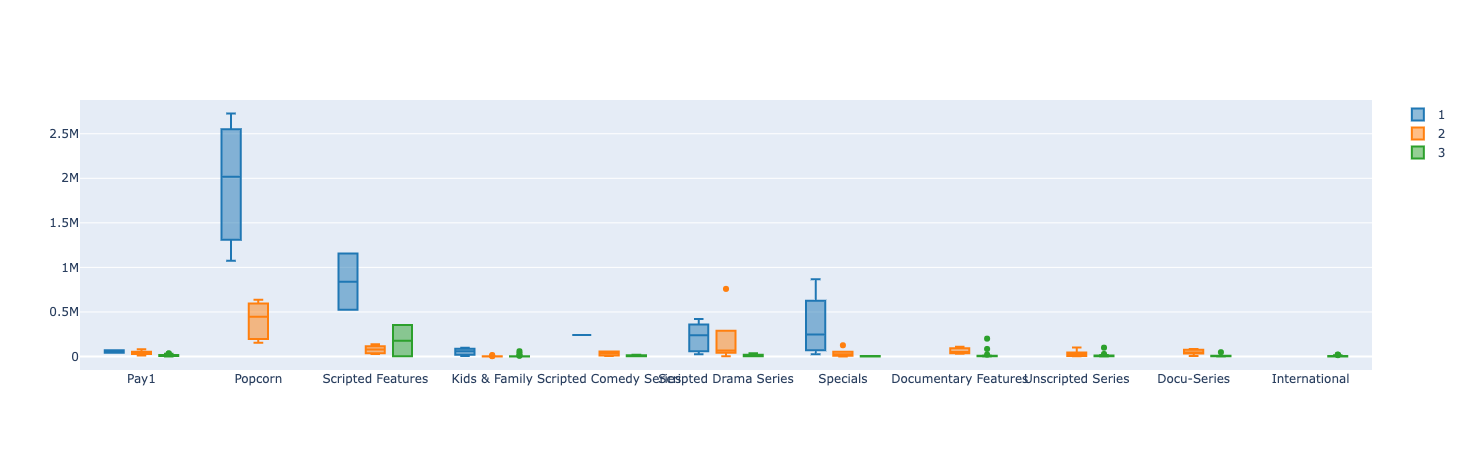

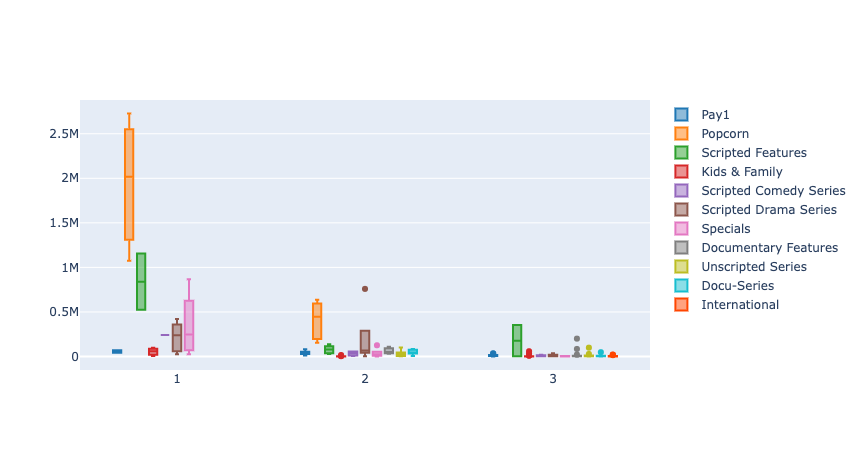

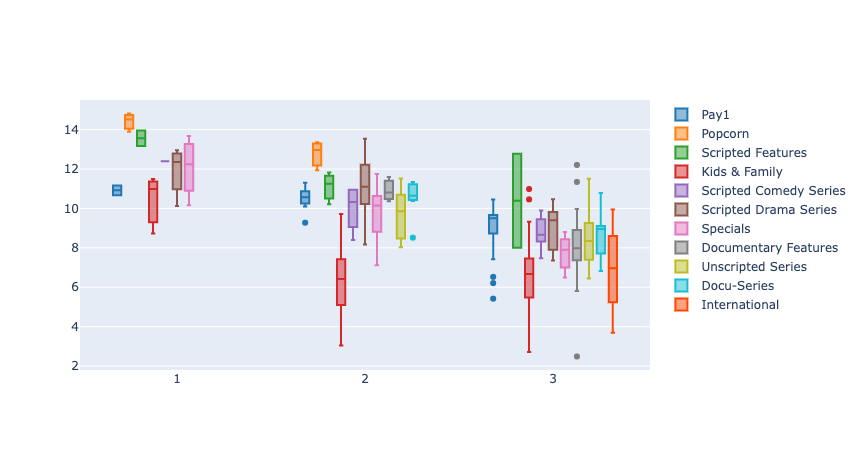

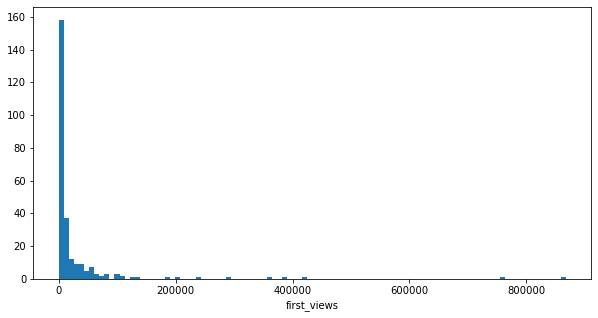

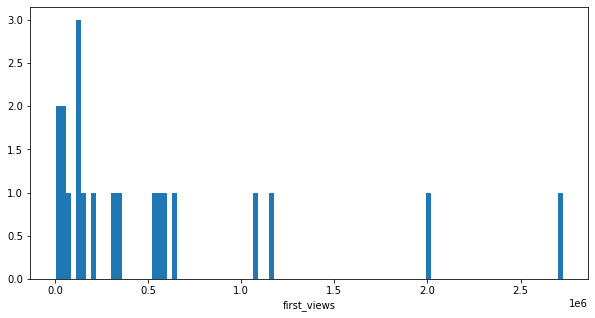

In [943]:
# target variable stats 
def get_distribution(df_in, grpby):
    display(df[['first_views','title_id'] + grpby].groupby(by=grpby).agg({'title_id':'nunique','first_views':['sum','mean','std','min', q10, q25, q50, q75, q90,'max']}).round())

def get_box_plot(df, y_var):
    fig, ax = plt.subplots(figsize = (20, 10))
    sns.boxplot(x='category',y='first_views', data=df, hue='tier', ax=ax, showfliers = False)
#     ax.set_ylabel(('first_views'))
    plt.show()
    
def get_hist_plot(df, y_var):
    fig, ax = plt.subplots(figsize = (10, 5))
    plt.hist(df[[y_var]], bins=100)
    ax.set_xlabel(y_var)
    plt.show()

def q10(x):
    return x.quantile(0.1)
def q25(x):
    return x.quantile(0.25)
def q50(x):
    return x.quantile(0.5)
def q75(x):
    return x.quantile(0.75)
def q90(x):
    return x.quantile(0.9)

display(df[['first_views']].describe(percentiles=percents))

get_distribution(df, ['tier','content_category',])
get_distribution(df, ['tier','content_category','category',])


fig=go.Figure()
for i, tier in enumerate(df['tier'].unique()):
    df_plot=df[df['tier']==tier]
    fig.add_trace(go.Box(x=df_plot['category'], y=df_plot['first_views'],
                         line=dict(color=colorlist[i]),
                         name=f'{tier}'))

fig.update_layout(boxmode='group', xaxis_tickangle=0)
fig.show()

fig=go.Figure()
for i, tier in enumerate(df['category'].unique()):
    df_plot=df[df['category']==tier]
    fig.add_trace(go.Box(x=df_plot['tier'], y=df_plot['first_views'],
                         line=dict(color=colorlist[i]),
                         name=f'{tier}'))

fig.update_layout(boxmode='group', xaxis_tickangle=0)
fig.show()


fig=go.Figure()
for i, tier in enumerate(df['category'].unique()):
    df_plot=df[df['category']==tier]
    fig.add_trace(go.Box(x=df_plot['tier'], y=df_plot['first_views_log'],
                         line=dict(color=colorlist[i]),
                         name=f'{tier}'))

fig.update_layout(boxmode='group', xaxis_tickangle=0)
fig.show()

get_hist_plot(df[~(df.category.isin(["Scripted Features","Popcorn"]))], 'first_views')
get_hist_plot(df[(df.category.isin(["Scripted Features","Popcorn"]))], 'first_views')

# plt.xticks(rotation=45)

count    2.820000e+02
mean     6.510319e+04
std      2.438481e+05
min      1.200000e+01
25%      1.304250e+03
50%      5.736000e+03
75%      2.803425e+04
max      2.727097e+06
Name: first_views, dtype: float64

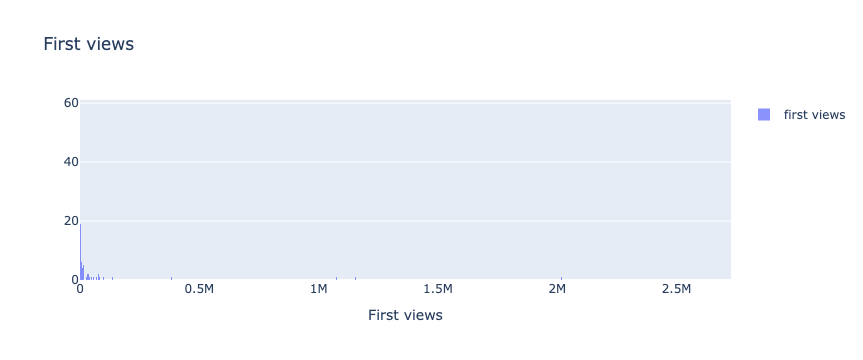

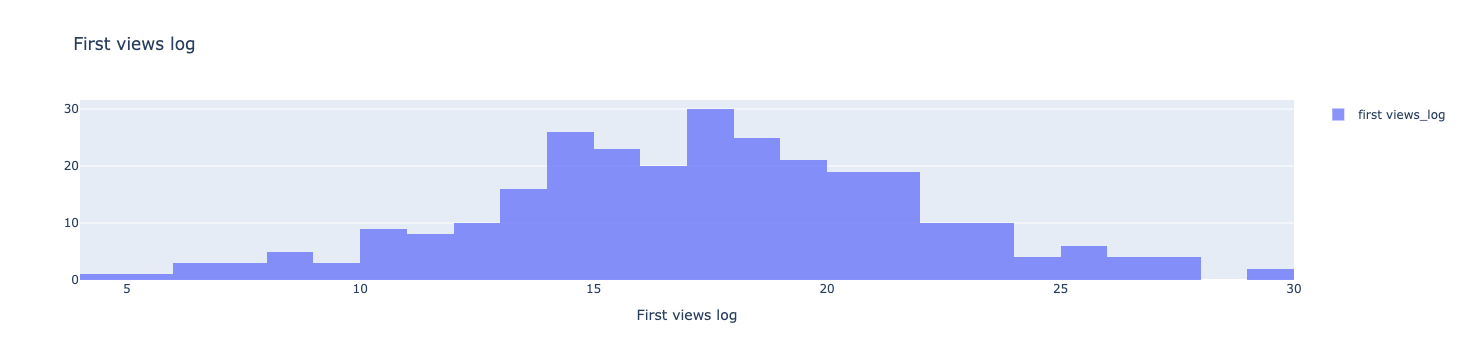

In [650]:
df['first_views_log'] = np.log(df['first_views'])*2
display(df['first_views'].describe())


kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views'] ## Variables to be plotted
        ,'title':'First views'  ## Plot title
        ,'labellist':['first views']
       ,'option':{'xbins':{'size':1000}}} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)


kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views_log'] ## Variables to be plotted
        ,'title':'First views log'  ## Plot title
        ,'labellist':['first views_log']} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)

# Features
augment input data? 
get more features?
regularize 
lightgbm, catboost, xgboost, random forest, 

In [156]:
print(df.columns)
print(df_raw.columns)

target = 'first_views_log'

features_cat=[
    'start_year',
    'start_quarter',
    'start_month',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
    'season_number',
    'premiering_hours_runtime',
    'ref_tot',
    'ref_ref_featured_in',
    'ref_ref_tot'
]

display(df[features_cat + features_cont].describe(percentiles=percents))

## Bivariate 
for i in features_cat:
    display(df.groupby(by=i).mean())


Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'program_type', 'effective_start_date', 'first_views',
       'premiering_hours_runtime', 'start_year', 'start_month',
       'start_year_month', 'start_quarter', 'first_views_log',
       'asset_title_long', 'imdb_id', 'genres', 'title_type', 'ref_follows',
       'ref_remake_of', 'ref_spin_off_from', 'ref_ref_featured_in',
       'ref_ref_spoofed_in', 'ref_tot', 'ref_ref_tot'],
      dtype='object')
Index(['Unnamed: 0', 'title_id', 'title_name', 'season_number',
       'content_category', 'content_source', 'program_type', 'category',
       'tier', 'effective_start_date', 'request_date', 'premiere_ind',
       'asset_premiere_count', 'premiering_hours_runtime', 'first_views',
       'hours_viewed', 'days_since_premiere', 'days_on_platform',
       'finished_window_flag'],
      dtype='object')


,start_year,start_quarter,start_month,tier,season_number,premiering_hours_runtime,ref_tot,ref_ref_featured_in,ref_ref_tot
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,2020.224700,3.168096,8.555746,2.401372,16.638079,3.407774,0.066895,4.763293,5.962264
std,0.417743,1.075761,3.267548,0.580435,20.438014,3.302219,0.398431,37.867225,46.159986
min,2020.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,2020.000000,1.000000,1.000000,1.000000,0.000000,0.154980,0.000000,0.000000,0.000000
5%,2020.000000,1.000000,2.000000,2.000000,0.000000,0.432000,0.000000,0.000000,0.000000
10%,2020.000000,1.000000,3.000000,2.000000,0.000000,0.432000,0.000000,0.000000,0.000000
25%,2020.000000,2.000000,6.000000,2.000000,1.000000,0.956000,0.000000,0.000000,0.000000
50%,2020.000000,4.000000,11.000000,2.000000,2.000000,1.840000,0.000000,0.000000,0.000000
75%,2020.000000,4.000000,11.000000,3.000000,42.000000,5.049500,0.000000,0.000000,0.000000


,tier,season_number,first_views,premiering_hours_runtime,start_month,start_quarter,first_views_log,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
start_year,,,,,,,,,,,,,,
2020,2.351770,20.993363,29305.774336,3.436235,10.011062,3.637168,3.165318,0.011062,0.024336,0.002212,2.011062,0.907080,0.037611,2.918142
2021,2.572519,1.610687,106012.175573,3.309573,3.534351,1.549618,3.836713,0.106870,0.045802,0.015267,14.259542,2.206107,0.167939,16.465649


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,first_views_log,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
start_quarter,,,,,,,,,,,,,,
1,2.603175,1.825397,140918.349206,3.481619,2021.000000,1.873016,3.853406,0.095238,0.063492,0.000000,4.634921,0.571429,0.158730,5.206349
2,2.514019,1.299065,63381.925234,3.157467,2020.598131,5.261682,3.916147,0.093458,0.018692,0.018692,18.738318,5.560748,0.130841,24.299065
3,2.743902,0.804878,24601.268293,3.375085,2020.048780,8.073171,3.673365,0.000000,0.024390,0.012195,1.195122,0.158537,0.036585,1.353659
4,2.241692,28.338369,28570.329305,3.482731,2020.000000,11.012085,2.931495,0.009063,0.027190,0.000000,1.154079,0.166163,0.036254,1.320242


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_quarter,first_views_log,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
start_month,,,,,,,,,,,,,,
1,2.730769,3.192308,61066.500000,4.844846,2021.000000,1.0,3.841165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.526316,1.000000,104988.210526,2.709789,2021.000000,1.0,4.166751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.500000,0.722222,294186.166667,2.327222,2021.000000,1.0,3.540335,0.333333,0.222222,0.000000,16.222222,2.000000,0.555556,18.222222
4,2.565217,1.695652,109311.478261,3.575696,2021.000000,2.0,3.933038,0.043478,0.086957,0.086957,46.913043,8.000000,0.217391,54.913043
5,2.303030,1.272727,74209.606061,4.034000,2020.636364,2.0,4.318932,0.151515,0.000000,0.000000,12.606061,1.939394,0.151515,14.545455
6,2.627451,1.137255,35662.450980,2.401686,2020.392157,2.0,3.647904,0.078431,0.000000,0.000000,10.000000,6.803922,0.078431,16.803922
7,2.636364,0.636364,17220.181818,2.380636,2020.181818,3.0,3.834980,0.000000,0.045455,0.000000,0.272727,0.000000,0.045455,0.272727
8,2.750000,0.656250,33067.187500,2.680719,2020.000000,3.0,3.748995,0.000000,0.000000,0.031250,2.875000,0.406250,0.031250,3.281250
9,2.821429,1.107143,20725.357143,4.950000,2020.000000,3.0,3.459948,0.000000,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000


,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter,first_views_log,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
tier,,,,,,,,,,,,,,
1,0.464286,600019.107143,3.293286,2020.428571,6.178571,2.357143,5.282158,0.500000,0.250000,0.071429,47.928571,9.178571,0.821429,57.107143
2,31.853242,27286.290102,3.516819,2020.109215,9.914676,3.631399,3.153115,0.010239,0.020478,0.003413,1.303754,0.501706,0.034130,1.805461
3,1.351145,8925.141221,3.298061,2020.332061,7.290076,2.736641,3.288436,0.007634,0.015267,0.000000,4.019084,1.125954,0.022901,5.145038


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter,first_views_log,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
content_category,,,,,,,,,,,,,,,
movies,2.524590,0.000000,163417.016393,1.649951,2020.393443,7.081967,2.655738,4.118800,0.122951,0.131148,0.02459,19.934426,5.139344,0.278689,25.073770
series,2.365909,22.045455,12713.377273,4.013970,2020.177273,8.997727,3.320455,3.074387,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
special,2.428571,0.000000,76335.380952,0.918619,2020.238095,7.857143,2.952381,3.719485,0.190476,0.047619,0.00000,16.428571,3.428571,0.238095,19.857143


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter,first_views_log,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
program_type,,,,,,,,,,,,,,,
acquired,2.292308,0.000000,262860.292308,1.782246,2020.476923,6.430769,2.446154,4.549322,0.230769,0.230769,0.046154,37.076923,9.630769,0.507692,46.707692
original,2.415058,18.725869,19397.463320,3.611749,2020.193050,8.822394,3.258687,3.161443,0.007722,0.003861,0.000000,0.708494,0.140927,0.011583,0.849421


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter,first_views_log,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
category,,,,,,,,,,,,,,,
Docu-Series,2.466667,1.000000,34286.266667,4.073133,2020.333333,6.933333,2.666667,4.217006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Documentary Features,2.930233,0.116279,16712.558140,1.819256,2020.348837,7.116279,2.651163,3.625419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
International,3.000000,1.491228,2804.859649,5.741193,2020.403509,7.175439,2.736842,2.933398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Kids & Family,2.186207,32.406897,3402.341379,3.137028,2020.041379,10.313793,3.748276,2.738533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pay1,2.568182,0.000000,24502.477273,1.692318,2020.340909,7.272727,2.750000,4.166935,0.090909,0.204545,0.022727,30.681818,7.340909,0.318182,38.022727
Popcorn,1.588235,0.000000,930364.352941,2.003529,2020.823529,4.470588,1.764706,5.682616,0.588235,0.352941,0.117647,52.411765,10.411765,1.058824,62.823529
Scripted Comedy Series,2.500000,1.875000,32287.812500,3.021813,2020.687500,4.375000,1.812500,4.103027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Scripted Drama Series,2.150000,1.500000,122635.150000,6.317900,2020.400000,6.100000,2.400000,4.463364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Scripted Features,2.000000,0.000000,235302.727273,2.000273,2020.363636,7.454545,2.818182,4.963325,0.090909,0.090909,0.000000,17.363636,11.545455,0.181818,28.909091


In [159]:
## Stepwise regression 
from sklearn.linear_model import LinearRegression

def run_regression(df, features_cat, features_cont, print_coeff=False):
    features = features_cat + features_cont
    x = df[features]
    ohe = OneHotEncoder(cols=features_cat, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df[features])

    # fit
    lm = LinearRegression()
    model = lm.fit(x_ohe, df[target])
    
    # predict
    y_pred = model.predict(x_ohe)

    print(features)
    # Fit (in sample)
    print('MAE: %.2f'
      % MAE(df[target], y_pred))
    print('r2: %.2f'
      % r2_score(df[target], y_pred))
    
    # coeffs
    if print_coeff==True:
        df_coeff = pd.concat([pd.DataFrame(x_ohe.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1) 
        df_coeff.columns=['feature','coeff']
        df_coeff['coeff_abs']=df_coeff.coeff.abs()
        display(df_coeff.sort_values(by='coeff_abs', ascending=False))
        
    return


features_cat_tot=[
    'tier',
    'content_category',
    'category',
    'program_type',
    'start_quarter',
    'start_year',
    'start_month',
]

features_cont_tot=[
    'season_number',
    'ref_tot',
    'ref_ref_featured_in',
    'ref_ref_spoofed_in'
]


target = 'first_views_log'
features_cont=[]

i=0
for i in range(0,len(features_cat_tot)):
    run_regression(df, features_cat_tot[0:i+1], features_cont)
    
for i in range(0,len(features_cont_tot)):
    run_regression(df, features_cat_tot, features_cont_tot[0:i+1])



is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


['tier']
MAE: 0.76
r2: 0.18
['tier', 'content_category']
MAE: 0.69
r2: 0.29
['tier', 'content_category', 'category']
MAE: 0.54
r2: 0.57
['tier', 'content_category', 'category', 'program_type']
MAE: 0.54
r2: 0.57


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


['tier', 'content_category', 'category', 'program_type', 'start_quarter']
MAE: 0.54
r2: 0.58
['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year']
MAE: 0.52
r2: 0.59


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year', 'start_month']
MAE: 0.52
r2: 0.60
['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year', 'start_month', 'season_number']
MAE: 0.49
r2: 0.63


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year', 'start_month', 'season_number', 'ref_tot']
MAE: 0.49
r2: 0.64
['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year', 'start_month', 'season_number', 'ref_tot', 'ref_ref_featured_in']
MAE: 0.49
r2: 0.64
['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year', 'start_month', 'season_number', 'ref_tot', 'ref_ref_featured_in', 'ref_ref_spoofed_in']
MAE: 0.49
r2: 0.64


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


## Prediction

In [260]:
def _encode(df, categoricals):
    """
    perform category encoding on the data
    :param df: dataframe to be encoded
    :param categoricals: list of name of categorical columns
    :return ohe, x_ohe: OHE object and OHE-encoded data
    """
    ohe = OneHotEncoder(cols=categoricals, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df)
    return ohe, x_ohe


def train_lr(df_train, features_cat, features_cont, target):
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
  
    # fit
    lm = LinearRegression()
    model = lm.fit(x_ohe, y_train)
       
    return model, ohe

def predict_lr(df_test, model, ohe, features_cat, features_cont, target, postfix):    
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    y_pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_{}'.format(postfix)] = np.exp(pred)
  
    rmse = np.sqrt(MSE(np.exp(y_test), np.exp(pred)))
    mae = MAE(np.exp(y_test), np.exp(pred))
    print("Aggergate error : % f" %(np.exp(pred).sum()-np.exp(y_test).sum()))
    print("RMSE : % f" %(rmse))
    print("MAE : % f" %(mae)) 
    
    return df_pred

def train_xgb(df_train, features_cat, features_cont, target, param):
  
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
    dm_train = xgb.DMatrix(x_ohe, label=y_train)
    
    ## train 
    model = xgb.train(params = param, dtrain = dm_train, num_boost_round = 10)
    
    return model, ohe

def predict_xgb(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test, label=y_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[list(set(['title_name', 'title_id','category','season_number'] + features_cat + features_cont + ['first_views']))]
    df_pred['first_views_log_{}'.format(postfix)] = pred

    return df_pred



def train_lgbm(df_train, features_cat, features_cont, target, param):       
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)

    x_train = lightgbm.Dataset(x_ohe, label=y_train)
    model = lightgbm.train(param, x_train, verbose_eval = -1)

    return model, ohe


def predict_lgbm(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_log_{}'.format(postfix)] = pred
    df_pred.head()

    return df_pred


def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')



## Features 

target = 'first_views_log'

features_cat=[
    'start_year',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
#     'season_number',
    'ref_tot',
#     'ref_ref_tot'
]


### Model parameters 
param_xgb = {"booster":"gbtree",
             "objective":"reg:squarederror"}


param_lgbm = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}



#### Get train/pred data

In [512]:
date_eval_end = '2021-07-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_0922.csv')
df= df_raw.copy()
df['effective_start_date'] = pd.to_datetime(df['effective_start_date'])
df = df[df['effective_start_date']<=date_eval_end]

grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date']
df = df[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
df['start_year'] = pd.to_datetime(df['effective_start_date']).dt.year
df['start_month'] = pd.to_datetime(df['effective_start_date']).dt.month
df['start_year_month'] = df['effective_start_date'].dt.strftime('%Y-%m')
df['start_quarter'] = df['effective_start_date'].dt.quarter
df = df[df.title_name!='Dune']


print(df.shape)
print('# title: ', df.title_name.nunique())
df = df[df['first_views']!=0]
print(df.shape)
df['first_views_log'] = np.log(df['first_views'])

## add imdb features 
df_imdb = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered.csv')
print(df_imdb.columns)

col = ['title_id', 'asset_title_long', 'imdb_id', 'genres', 'title_type',
       'ref_follows', 'ref_remake_of', 'ref_spin_off_from', 'ref_version_of',
      'ref_ref_featured_in','ref_ref_spoofed_in']

df = df.merge(df_imdb[col], how='left', on=['title_id'])
df['ref_tot'] = df[['ref_follows','ref_remake_of','ref_spin_off_from','ref_version_of']].sum(axis=1)
df['ref_ref_tot'] = df[['ref_ref_featured_in','ref_ref_spoofed_in']].sum(axis=1)

## Clean data and make a copy for evaluation
df = df.fillna(0)
df.head(2)
print(df.shape)
print('# title: ', df.title_name.nunique())
print(df.columns)
df=df.drop_duplicates(subset=['title_id','tier','category','season_number'],keep='first')
print(df.shape)

df_actual = df.copy()

## Adjust tier feature for train & pred 
df.loc[(df['category']=='Popcorn') & (df['tier']==1), ['tier']] = 0
df.loc[(df['category']=='Popcorn') & (df['tier']==2), ['tier']] = 1

df_train = df.copy()

(281, 14)
# title:  237
(281, 14)
Index(['Unnamed: 0', 'tier', 'content_category', 'category', 'title_name',
       'title_id', 'season_number', 'program_type', 'first_views',
       'title_type', 'imdb_id', 'asset_title_long', 'genres', 'ref_follows',
       'ref_spin_off_from', 'ref_remake_of', 'ref_version_of',
       'ref_ref_featured_in', 'ref_ref_spoofed_in'],
      dtype='object')
(582, 27)
# title:  237
Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'program_type', 'effective_start_date', 'first_views',
       'premiering_hours_runtime', 'start_year', 'start_month',
       'start_year_month', 'start_quarter', 'first_views_log',
       'asset_title_long', 'imdb_id', 'genres', 'title_type', 'ref_follows',
       'ref_remake_of', 'ref_spin_off_from', 'ref_version_of',
       'ref_ref_featured_in', 'ref_ref_spoofed_in', 'ref_tot', 'ref_ref_tot'],
      dtype='object')
(281, 27)


#### Train & predict

In [318]:
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01','2021-04-01', '2021-05-01', '2021-06-01']

In [319]:
## xgb w/ clean data  
features_cont_dev=[
    'season_number',
#     'ref_tot',
#     'ref_ref_tot',
]
postfix = 'dev'

df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb_dev)
#         display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}'])
#         display(df_pred[df_pred.category=='Popcorn'])
#     df_pred['first_views_{}'.format(postfix)] = (np.log(df_pred['first_views_{}'.format(postfix)])*lmbda+1)**(1/lmbda)
    df_pred_list.append(df_pred)  
df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])
df_pred_dev = df_out.copy()

display(df_pred_dev[df_pred_dev.category=='Popcorn'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



_____________________________________________________________
Aggregate actuals: Count: 97; Title-level mean: 91266;  Aggregate sum: 8852793
dev title-level MAE: 74418; aggregate %error: -67%; pred: 2897745; 


,category,start_year,title_name,tier,season_number,title_id,content_category,first_views,program_type,first_views_log_dev,first_views_dev
46,Popcorn,2021,The Little Things,1,0,GYA79hQZbUsI3gQEAAAB0,movies,635584,acquired,10.603066,40258.097656
43,Popcorn,2021,Judas and the Black Messiah,1,0,GYBmsKA4FaUnDdQEAAAAj,movies,319734,acquired,11.038846,62245.777344
50,Popcorn,2021,Tom & Jerry,1,0,GYEb9QwLgFF9_ZwEAAAA7,movies,595699,acquired,11.038846,62245.777344
3,Popcorn,2021,Godzilla vs. Kong,0,0,GYFEzmwNES16GkQEAAAAC,movies,2017162,acquired,10.197797,26843.978516
5,Popcorn,2021,Mortal Kombat,0,0,GYGYKfQwaKLheqwEAAAEC,movies,1074951,acquired,12.333849,227259.765625
48,Popcorn,2021,Those Who Wish Me Dead,1,0,GYH8W5wtYpsPDwgEAAAAC,movies,153249,acquired,12.719986,334364.156250
42,Popcorn,2021,In The Heights,1,0,GYK0x7gXCza4OwwEAAADl,movies,195239,acquired,12.605723,298260.750000
45,Popcorn,2021,The Conjuring: The Devil Made Me Do It,1,0,GYLEE7gB0zcLCwgEAAAHj,movies,571005,acquired,12.605723,298260.750000


In [526]:
## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot',
]
postfix = 'dev_a'

df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb_dev)
#         display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))
#         display(df_pred[df_pred.category=='Popcorn'])
#     df_pred['first_views_{}'.format(postfix)] = (np.log(df_pred['first_views_{}'.format(postfix)])*lmbda+1)**(1/lmbda)
    df_pred_list.append(df_pred)  
df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])
df_pred_dev_a = df_out.copy()

display(df_pred_dev_a[df_pred_dev_a.category=='Popcorn'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



_____________________________________________________________
Aggregate actuals: Count: 97; Title-level mean: 91266;  Aggregate sum: 8852793
dev_a title-level MAE: 60581; aggregate %error: -38%; pred: 5504268; 


,category,start_year,title_name,tier,season_number,title_id,content_category,ref_tot,first_views,program_type,first_views_log_dev_a,first_views_dev_a
46,Popcorn,2021,The Little Things,1,0,GYA79hQZbUsI3gQEAAAB0,movies,0.0,635584,acquired,486.623169,144590.437500
43,Popcorn,2021,Judas and the Black Messiah,1,0,GYBmsKA4FaUnDdQEAAAAj,movies,0.0,319734,acquired,485.791107,143419.546875
50,Popcorn,2021,Tom & Jerry,1,0,GYEb9QwLgFF9_ZwEAAAA7,movies,0.0,595699,acquired,485.791107,143419.546875
3,Popcorn,2021,Godzilla vs. Kong,0,0,GYFEzmwNES16GkQEAAAAC,movies,5.0,2017162,acquired,679.426331,789110.750000
5,Popcorn,2021,Mortal Kombat,0,0,GYGYKfQwaKLheqwEAAAEC,movies,2.0,1074951,acquired,677.186218,775091.000000
48,Popcorn,2021,Those Who Wish Me Dead,1,0,GYH8W5wtYpsPDwgEAAAAC,movies,0.0,153249,acquired,594.614136,389813.781250
42,Popcorn,2021,In The Heights,1,0,GYK0x7gXCza4OwwEAAADl,movies,0.0,195239,acquired,588.729858,370391.250000
45,Popcorn,2021,The Conjuring: The Devil Made Me Do It,1,0,GYLEE7gB0zcLCwgEAAAHj,movies,2.0,571005,acquired,630.508667,529039.187500


In [530]:
df[df.tier==3].shape[0]

188

In [594]:
## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot',
]
postfix = 'dev_b'

df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        print(1)
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        print(2)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)
    print(df_train_in[df_train_in.category=='Popcorn'].shape)
    display(df_train_in.groupby(by='tier').count())
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)
#     display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

#         display(df_pred[df_pred.category=='Popcorn'])
#     df_pred['first_views_{}'.format(postfix)] = (np.log(df_pred['first_views_{}'.format(postfix)])*lmbda+1)**(1/lmbda)
    df_pred_list.append(df_pred)  
df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])
df_pred_dev_b = df_out.copy()

display(df_pred_dev_b[df_pred_dev_b.category=='Popcorn'])

2021-01-01 86 (0, 27)
1
2
(0, 27)


,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
tier,,,,,,,,,,,,,,,,,,,,,,,,,,
1,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86
2,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86
3,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86


2021-02-01 105 (0, 27)
1
2
(0, 27)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
tier,,,,,,,,,,,,,,,,,,,,,,,,,,
1,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
2,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
3,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


2021-03-01 122 (1, 27)
1
(122, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
tier,,,,,,,,,,,,,,,,,,,,,,,,,,
0,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122
1,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122
2,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122
3,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122,122


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


2021-04-01 135 (2, 27)
1
(135, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
tier,,,,,,,,,,,,,,,,,,,,,,,,,,
0,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66
1,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204,204
2,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135
3,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


2021-05-01 146 (4, 27)
1
(146, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
tier,,,,,,,,,,,,,,,,,,,,,,,,,,
0,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
1,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246
2,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
3,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


2021-06-01 158 (5, 27)
1
(158, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
tier,,,,,,,,,,,,,,,,,,,,,,,,,,
0,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68
1,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248,248
2,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158
3,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



_____________________________________________________________
Aggregate actuals: Count: 97; Title-level mean: 91266;  Aggregate sum: 8852793
dev_b title-level MAE: 48119; aggregate %error: -23%; pred: 6825326; 


,category,start_year,title_name,tier,season_number,title_id,content_category,ref_tot,first_views,program_type,first_views_log_dev_b,first_views_dev_b
46,Popcorn,2021,The Little Things,1,0,GYA79hQZbUsI3gQEAAAB0,movies,0.0,635584,acquired,556.435486,2.782294e+05
43,Popcorn,2021,Judas and the Black Messiah,1,0,GYBmsKA4FaUnDdQEAAAAj,movies,0.0,319734,acquired,544.452332,2.495727e+05
50,Popcorn,2021,Tom & Jerry,1,0,GYEb9QwLgFF9_ZwEAAAA7,movies,0.0,595699,acquired,544.452332,2.495727e+05
3,Popcorn,2021,Godzilla vs. Kong,0,0,GYFEzmwNES16GkQEAAAAC,movies,5.0,2017162,acquired,820.582886,2.289030e+06
5,Popcorn,2021,Mortal Kombat,0,0,GYGYKfQwaKLheqwEAAAEC,movies,2.0,1074951,acquired,633.101990,5.406205e+05
48,Popcorn,2021,Those Who Wish Me Dead,1,0,GYH8W5wtYpsPDwgEAAAAC,movies,0.0,153249,acquired,599.668640,4.072106e+05
42,Popcorn,2021,In The Heights,1,0,GYK0x7gXCza4OwwEAAADl,movies,0.0,195239,acquired,609.702637,4.437914e+05
45,Popcorn,2021,The Conjuring: The Devil Made Me Do It,1,0,GYLEE7gB0zcLCwgEAAAHj,movies,2.0,571005,acquired,624.905762,5.047646e+05


In [525]:
features_cont_dev=[
    'season_number',
        'ref_tot',
#     'ref_ref_tot',
]

## xgb w/ clean data  
postfix = 'dev_c'

df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in['first_views_log'] =  np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb_dev)
#         display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))
#         display(df_pred[df_pred.category=='Popcorn'])
    df_pred_list.append(df_pred)  
df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])
df_pred_dev_c = df_out.copy()

display(df_out[df_out.category=='Popcorn'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



_____________________________________________________________
Aggregate actuals: Count: 97; Title-level mean: 91266;  Aggregate sum: 8852793
dev_c title-level MAE: 63199; aggregate %error: -38%; pred: 5449474; 


,category,start_year,title_name,tier,season_number,title_id,content_category,ref_ref_tot,first_views,program_type,first_views_log_dev_c,first_views_dev_c
46,Popcorn,2021,The Little Things,1,0,GYA79hQZbUsI3gQEAAAB0,movies,0.0,635584,acquired,459.354401,110273.585938
43,Popcorn,2021,Judas and the Black Messiah,1,0,GYBmsKA4FaUnDdQEAAAAj,movies,0.0,319734,acquired,483.485535,140218.453125
50,Popcorn,2021,Tom & Jerry,1,0,GYEb9QwLgFF9_ZwEAAAA7,movies,0.0,595699,acquired,483.485535,140218.453125
3,Popcorn,2021,Godzilla vs. Kong,0,0,GYFEzmwNES16GkQEAAAAC,movies,164.0,2017162,acquired,669.557800,728996.375000
5,Popcorn,2021,Mortal Kombat,0,0,GYGYKfQwaKLheqwEAAAEC,movies,238.0,1074951,acquired,650.250427,623028.812500
48,Popcorn,2021,Those Who Wish Me Dead,1,0,GYH8W5wtYpsPDwgEAAAAC,movies,0.0,153249,acquired,591.794128,380396.156250
42,Popcorn,2021,In The Heights,1,0,GYK0x7gXCza4OwwEAAADl,movies,0.0,195239,acquired,593.247742,385225.312500
45,Popcorn,2021,The Conjuring: The Devil Made Me Do It,1,0,GYLEE7gB0zcLCwgEAAAHj,movies,86.0,571005,acquired,663.475586,694008.312500


count    2.810000e+02
mean     6.532421e+04
std      2.442548e+05
min      1.200000e+01
25%      1.285000e+03
50%      5.800000e+03
75%      2.835400e+04
max      2.727097e+06
Name: first_views, dtype: float64

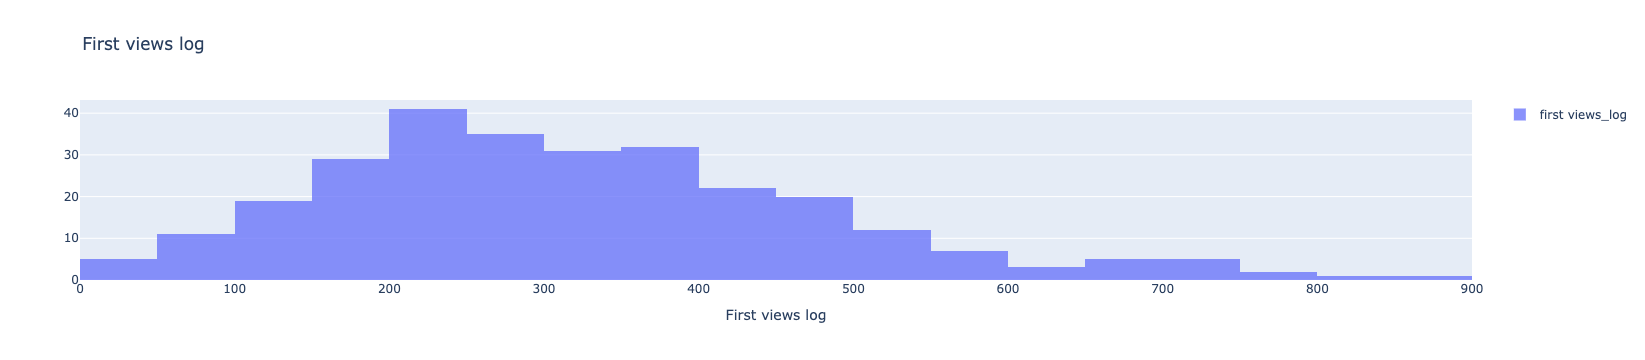

count    2.810000e+02
mean     6.532421e+04
std      2.442548e+05
min      1.200000e+01
25%      1.285000e+03
50%      5.800000e+03
75%      2.835400e+04
max      2.727097e+06
Name: first_views, dtype: float64

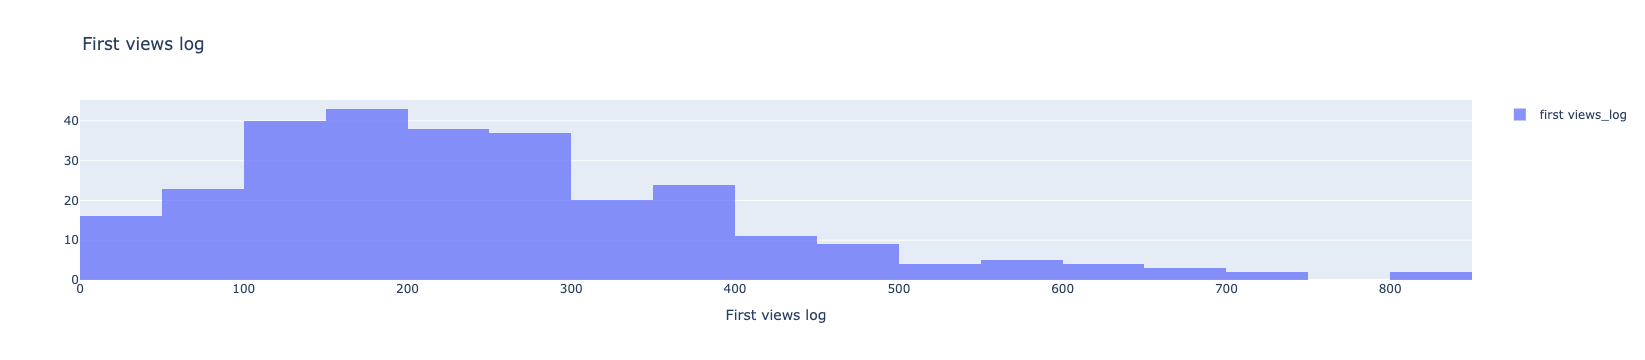

count    2.810000e+02
mean     6.532421e+04
std      2.442548e+05
min      1.200000e+01
25%      1.285000e+03
50%      5.800000e+03
75%      2.835400e+04
max      2.727097e+06
Name: first_views, dtype: float64

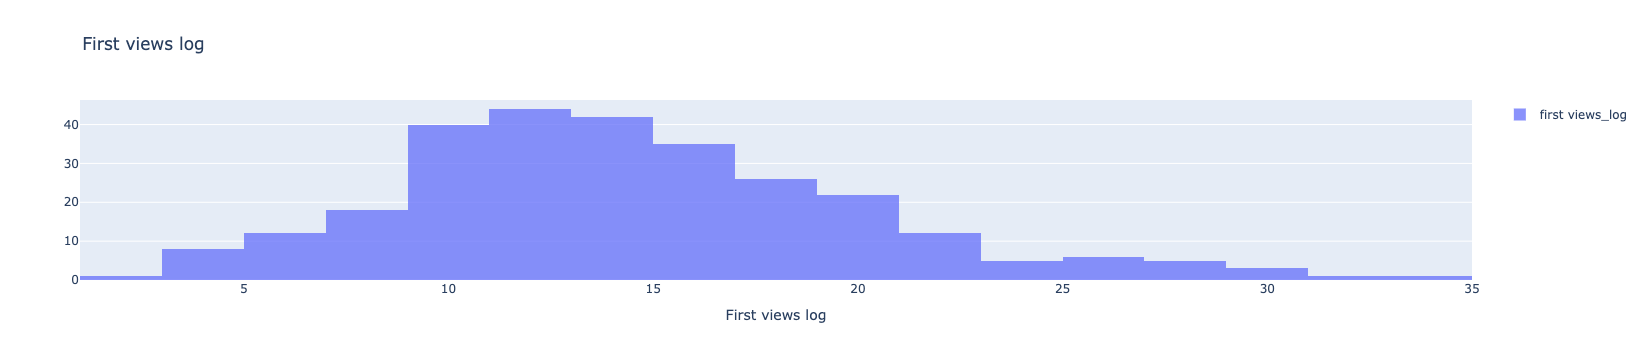

In [113]:
from scipy import stats 

lmbda=0.001
display(df['first_views'].describe())
df['first_views_log'] = np.log(df['first_views']**2)**2
# df['first_views_log'] = stats.boxcox(df['first_views'], lmbda=lmbda)**2

kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views_log'] ## Variables to be plotted
        ,'title':'First views log'  ## Plot title
        ,'labellist':['first views_log']} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)


lmbda=0.001
display(df['first_views'].describe())
df['first_views_log'] = np.log(df['first_views'])**2.5
# df['first_views_log'] = stats.boxcox(df['first_views'], lmbda=lmbda)**2

kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views_log'] ## Variables to be plotted
        ,'title':'First views log'  ## Plot title
        ,'labellist':['first views_log']} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)

# df['first_views_log'] = stats.boxcox(df['first_views'], lmbda=lmbda)
# df['first_views_l'] = (df['first_views_log']*lmbda+1)**(1/lmbda)
lmbda=0.1
display(df['first_views'].describe())
df['first_views_log'] = stats.boxcox(df['first_views'], lmbda=lmbda)

kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views_log'] ## Variables to be plotted
        ,'title':'First views log'  ## Plot title
        ,'labellist':['first views_log']} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)

## Evaluation

In [476]:
def get_baseline_clean(df_actual):
    ## Get cumulative median
    grpby_median = ['tier','category']
    df_median = df_actual.sort_values(by=['tier','category','effective_start_date'])
    df_median['first_views_median'] = (
        df_median.groupby(grpby_median)['first_views'].apply(lambda x: x.expanding().median()))
    
    ## Get last row of each day 
    grpby_median = ['tier','category', 'effective_start_date']
    df_median = pd.concat([df_median.groupby(grpby_median).tail(1)])
    df_median['eval_date'] = pd.to_datetime(df_median['effective_start_date']) + timedelta(days = 90)

    ## Get df_median
    grpby_median = ['tier','category', 'eval_date']
    df_median = df_median[grpby_median+['first_views_median',]]

    ## Set new index to fill missing dates in between 
    tier = df_median['tier'].unique()
    category = df_median['category'].unique()
    dates =  pd.date_range('2020-05-01','2021-10-02' , freq='1d')
    idx = pd.MultiIndex.from_product((tier, category, dates), names=grpby_median)
    df_median = df_median.set_index(grpby_median).reindex(idx).reset_index()

    ## fill with previous row per group 
    df_median[['first_views_median']] = df_median.groupby(['tier','category'])[['first_views_median']].ffill()
    df_median['eval_year_month'] = df_median['eval_date'].dt.strftime('%Y-%m')
    # ## Check 
    # display(df_actual[(df_actual.category=='Popcorn') & (df_actual.tier==2)].sort_values(by=['effective_start_date','tier'], ascending=True)[['title_name','tier','effective_start_date','first_views']])
    # df_median[(df_median['category']=='Popcorn') & (df_median.tier==2) & (df_median['train_date'].isin(['2020-03-01','2021-05-01','2021-06-01','2021-10-01']))]
    
    return df_median

def get_baseline_extrapolated(file_path, date_eval_start, grpby_actual):
    ## Get mixed median (clean + extrapolated training data, aggregate median)
    df_median_mx = pd.read_csv(file_path)
    df_median_mx['effective_start_date'] = pd.to_datetime(df_median_mx['effective_start_date'])
    df_median_mx['start_year_month'] = df_median_mx['effective_start_date'].dt.strftime('%Y-%m')
    
    median_mx_filter = (df_median_mx.effective_start_date<date_eval_start)
    grpby_median = ['tier','category']
    
    df_median_mx = df_median_mx[median_mx_filter][grpby_actual + ['first_views']].groupby(by=grpby_actual).agg({'first_views':'sum'}).reset_index()
    df_median_mx = df_median_mx[grpby_median + ['first_views']].groupby(by=grpby_median).agg({'first_views':'median'}).reset_index()
    df_median_mx = df_median_mx.rename(columns={'first_views':'first_views_median_mx'})
    df_median_mx['date_eval'] = date_eval_start
    df_median_mx['date_eval'] = pd.to_datetime(df_median_mx['date_eval'])
    df_median_mx['eval_year_month'] = df_median_mx['date_eval'].dt.strftime('%Y-%m')
    return df_median_mx

    

## Get actuals & baseline 

## Get actuals 
grpby_actual= ['tier','content_category','category','title_name', 'title_id','season_number','program_type',
        'effective_start_date', 'start_year_month','finished_window_flag']


# df_actual_raw = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_0922.csv')
# df_actual_raw['effective_start_date'] = pd.to_datetime(df_actual_raw['effective_start_date'])
# df_actual_raw['start_year'] = df_actual_raw['effective_start_date'].dt.year
# df_actual_raw['start_year_month'] = df_actual_raw['effective_start_date'].dt.strftime('%Y-%m')
# df_actual = df_actual_raw[['first_views'] + grpby_actual].groupby(by=grpby_actual).sum().reset_index()

# Get df_eval_actuals
date_eval_start = '2021-01-01'
date_eval_end = '2021-07-01'
test_filter = (df_actual.effective_start_date>=date_eval_start) & (df_actual.effective_start_date<date_eval_end)
df_eval_actuals = df_actual[test_filter] 

## Get clean baseline median; month-tier-category cumulative median
df_median = get_baseline_clean(df_actual)
df_median = df_median.groupby(['tier','category', 'eval_year_month']).head(1)


## Get extrapolated baseline
df_median_mx = []
for date, date_start in zip(['0101','0201','0301','0401','0501', '0601'], ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_{date}.csv'
    df_temp = get_baseline_extrapolated(file_path, date_start, grpby_actual)
    df_median_mx.append(df_temp)
df_median_mx = pd.concat(df_median_mx)
    
# # # ## Get base model (clean + extrapolated training data, day-median summed as total)
# df_median_mx_decay = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_0601.csv')
# df_median_mx_decay = df_median_mx_decay[grpby_median + ['predicted_first_views']].groupby(by=grpby_median).agg({'predicted_first_views':'sum'}).reset_index()
# df_median_mx_decay = df_median_mx_decay.rename(columns={'predicted_first_views':'first_views_median_mx_decay'})



In [ ]:
df_median_mx[]

In [595]:
### Get df_eval 


def evaluate_pred_group(df_plt, grpby, key, pred_list):
    print('')
    print('_____________________________________________________________')
    for quarter, group in df_plt.groupby(grpby):
        actuals_mean=group['first_views'].mean()
        actuals_sum=group['first_views'].sum()
        print('_____________________________________________________________')
        print(f'{key} {quarter} actuals: Count: {group.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
        for i in ['median_mx'] + list_postfix:  
            mae = MAE(group['first_views'], group[f'first_views_{i}'])
            pred= group[f'first_views_{i}'].sum()
            print(f'{key} {quarter} {i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals_sum)/actuals_sum*100:.0f}%; pred: {pred:.0f}; ')
    return


list_postfix = ['dev', 'dev_a', 'dev_b', 'dev_c']

df_eval = df_eval_actuals.merge(df_median_mx, left_on=['tier','category', 'start_year_month'], right_on=['tier','category', 'eval_year_month'], how='left')\
        .merge(df_pred_dev[['title_name','category','season_number', 'first_views_dev']], on=['title_name','category','season_number'], how='left')\
        .merge(df_pred_dev_a[['title_name','category','season_number', 'first_views_dev_a']], on=['title_name','category','season_number'], how='left')\
        .merge(df_pred_dev_b[['title_name','category','season_number', 'first_views_dev_b']], on=['title_name','category','season_number'], how='left')\
        .merge(df_pred_dev_c[['title_name','category','season_number', 'first_views_dev_c']], on=['title_name','category','season_number'], how='left')\

print(df_eval.shape)
# print(df_eval.isnull().sum())
# print(df_eval.columns)

df_eval = df_eval.dropna()
df_eval['start_year'] = pd.to_datetime(df_eval['effective_start_date']).dt.year
df_eval['start_month'] = pd.to_datetime(df_eval['effective_start_date']).dt.month
df_eval['start_year_month'] = df_eval['effective_start_date'].dt.strftime('%Y-%m')
df_eval['start_quarter'] = df_eval['effective_start_date'].dt.quarter

evaluate_pred(df_eval, ['median_mx'] + list_postfix)
evaluate_pred_group(df_eval, ['start_quarter'], 'Quarter', list_postfix)

print('')
print('Quarter-Popcorn')
evaluate_pred_group(df_eval[df_eval.category=='Popcorn'], ['start_quarter'], 'Quarter', list_postfix)
print('')
print('Quarter-Tier')
evaluate_pred_group(df_eval, ['start_quarter', 'tier'], 'Quarter-tier', list_postfix)


(97, 33)

_____________________________________________________________
Aggregate actuals: Count: 94; Title-level mean: 86207;  Aggregate sum: 8103425
median_mx title-level MAE: 71286; aggregate %error: -11%; pred: 7239182; 
dev title-level MAE: 69862; aggregate %error: -67%; pred: 2687531; 
dev_a title-level MAE: 55190; aggregate %error: -38%; pred: 5048434; 
dev_b title-level MAE: 45662; aggregate %error: -20%; pred: 6445334; 
dev_c title-level MAE: 57369; aggregate %error: -38%; pred: 5013070; 

_____________________________________________________________
_____________________________________________________________
Quarter 1 actuals: Count: 49; Title-level mean: 94947;  Aggregate sum: 4652397
Quarter 1 median_mx title-level MAE: 60708; aggregate %error: -10%; pred: 4194392; 
Quarter 1 dev title-level MAE: 82176; aggregate %error: -83%; pred: 805365; 
Quarter 1 dev_a title-level MAE: 65161; aggregate %error: -54%; pred: 2146849; 
Quarter 1 dev_b title-level MAE: 41009; aggregate %e

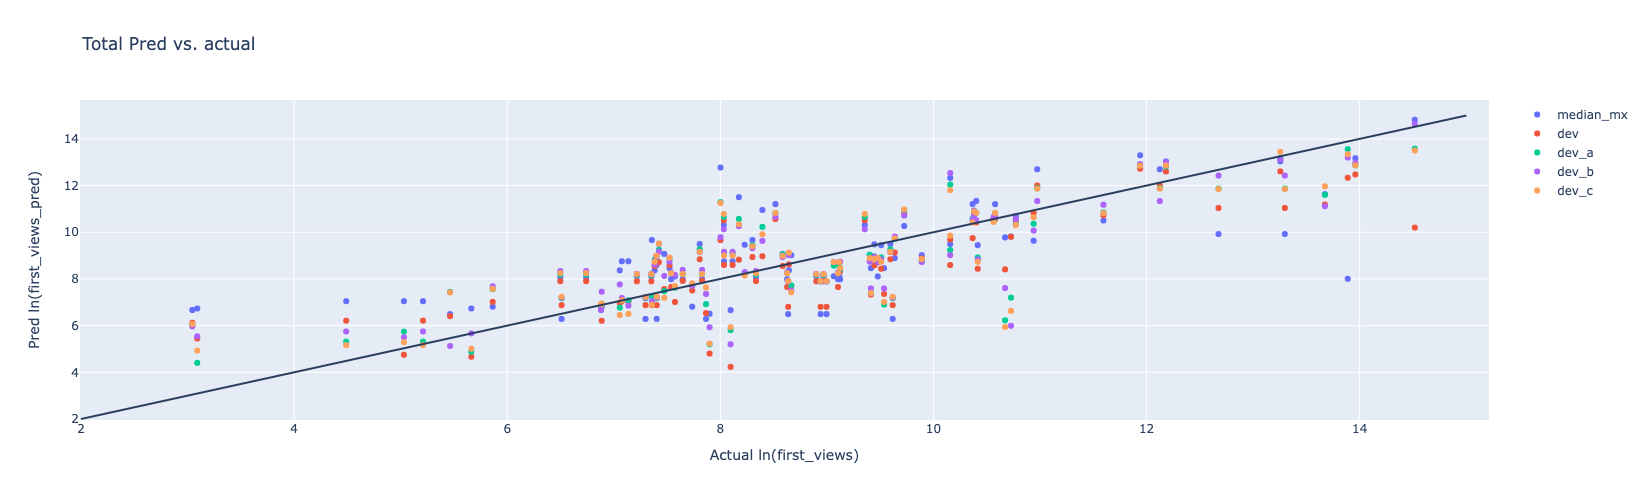

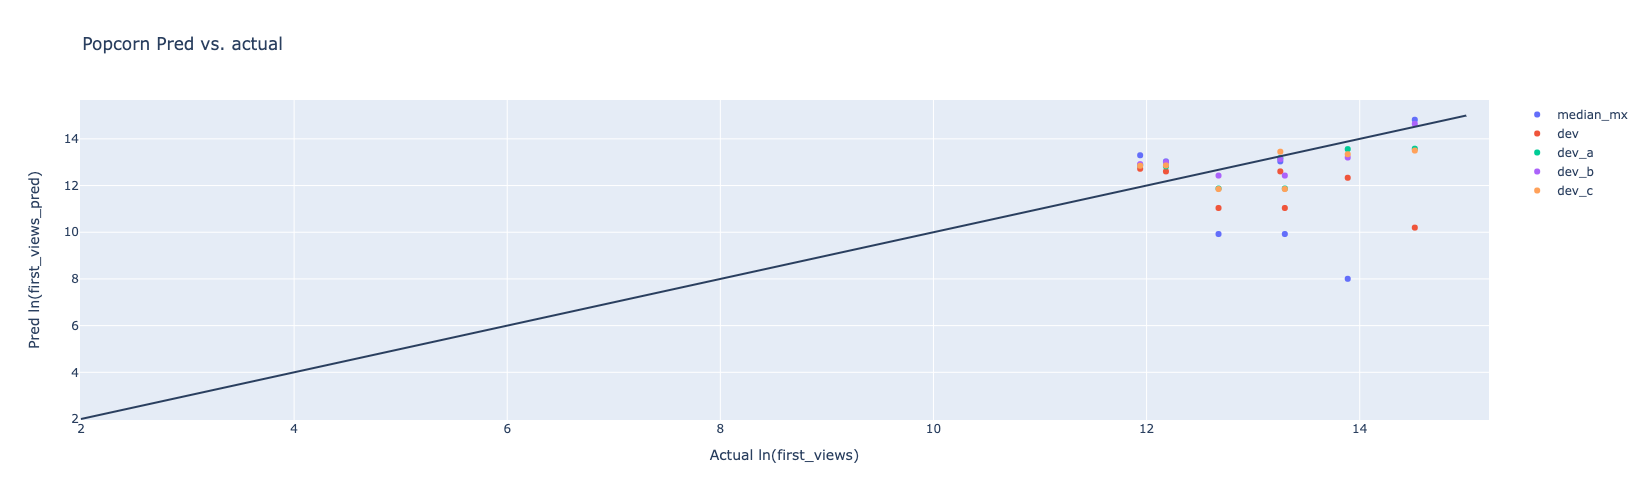

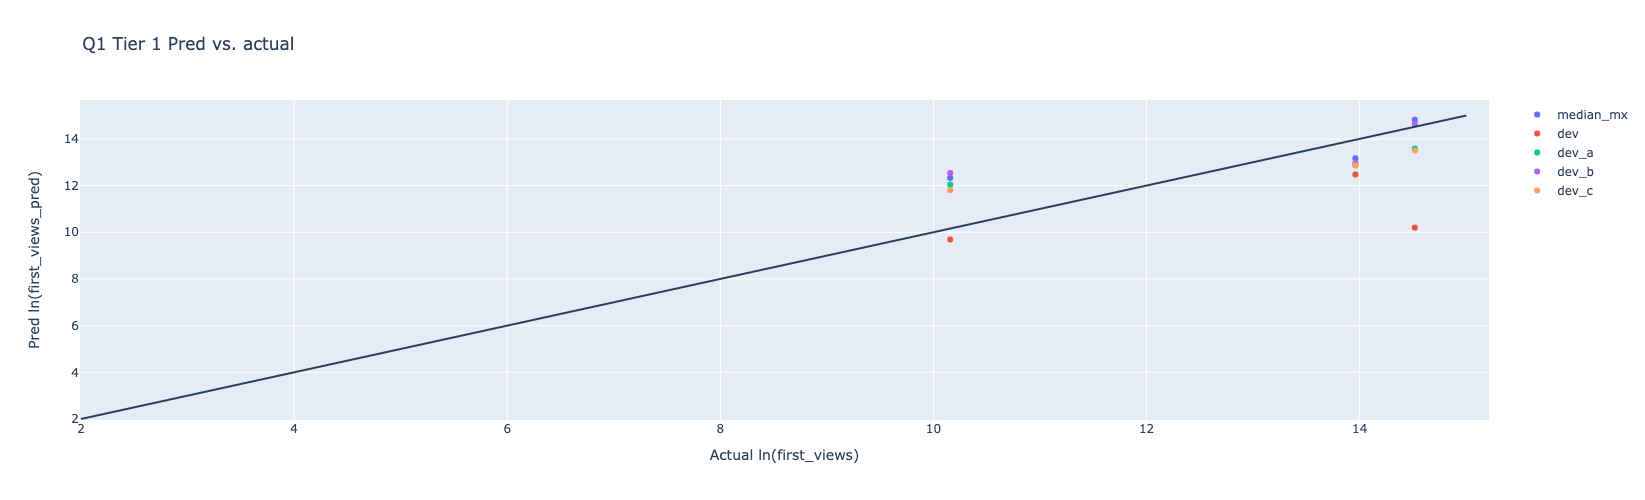

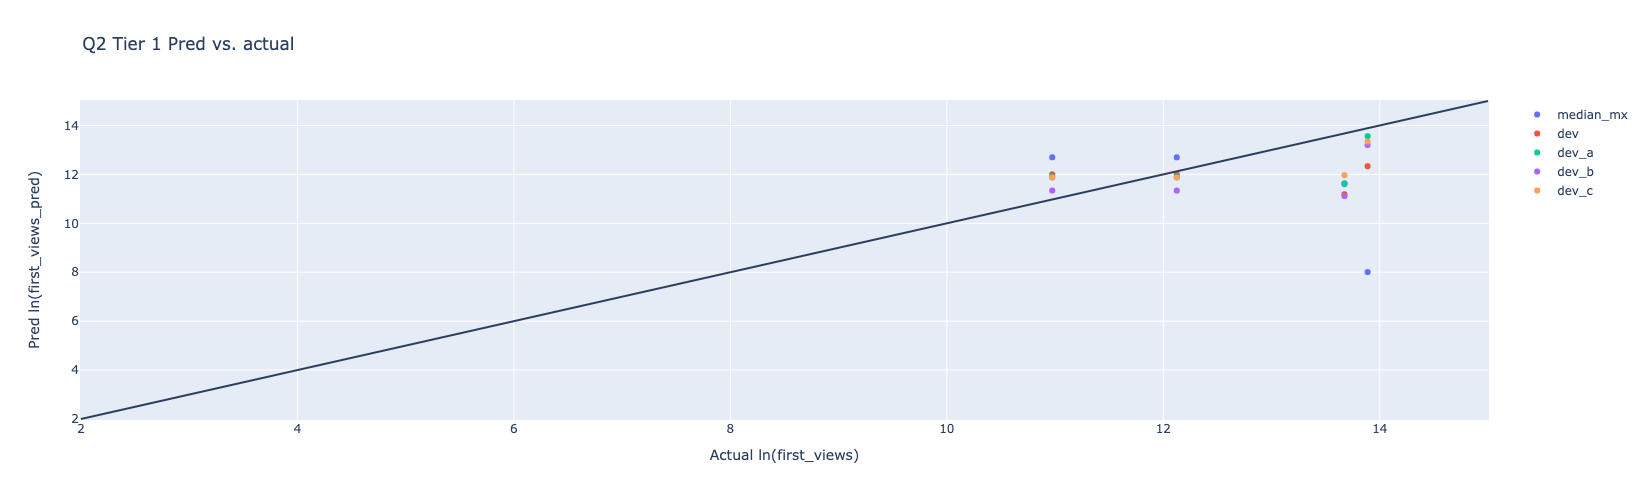

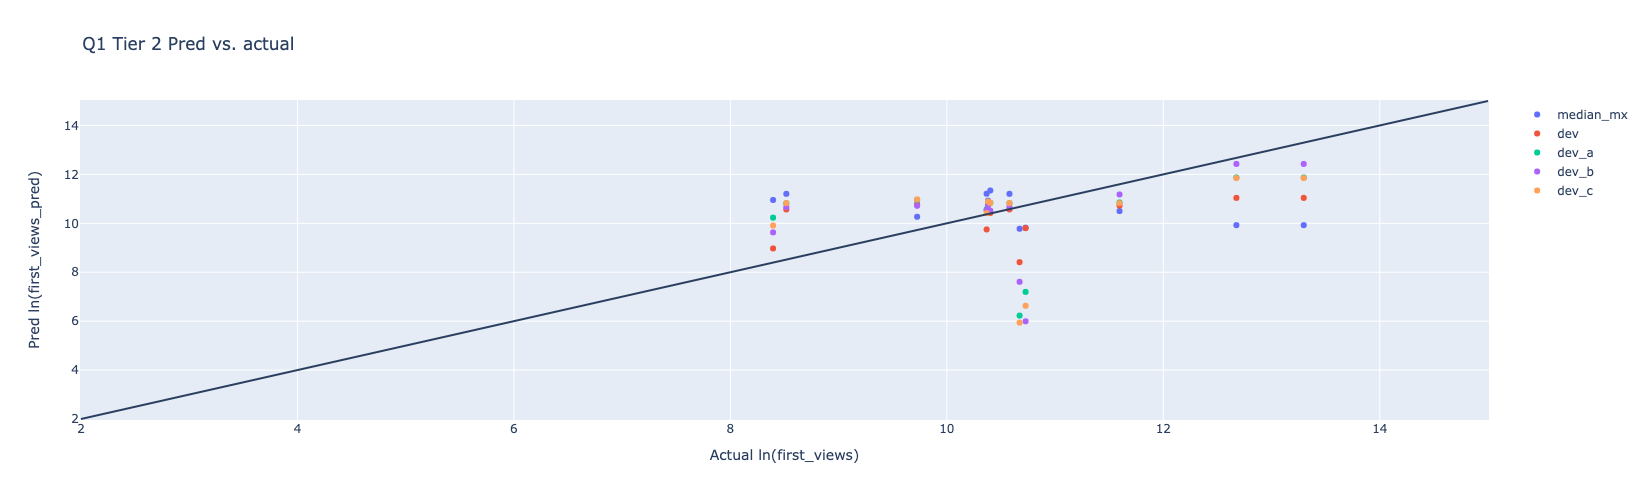

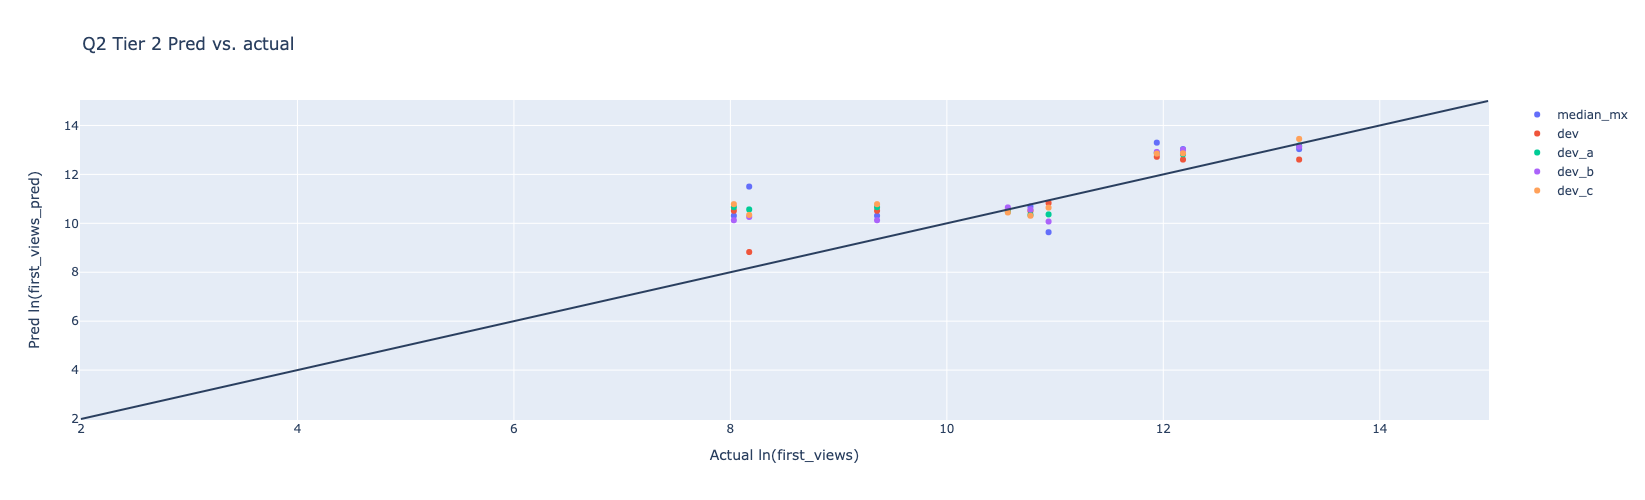

In [596]:
df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_dev_log'] = np.log(df_eval['first_views_dev'])
# df_eval['first_views_median_log'] = np.log(df_eval['first_views_median'])
df_eval['first_views_median_mx_log'] = np.log(df_eval['first_views_median_mx'])
df_eval['first_views_dev_a_log'] = np.log(df_eval['first_views_dev_a'])
df_eval['first_views_dev_b_log'] = np.log(df_eval['first_views_dev_b'])
df_eval['first_views_dev_c_log'] = np.log(df_eval['first_views_dev_c'])


def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i in ['median_mx'] + list_postfix:
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=i,
                    text=df_plt['start_year_month'] + " " + df_plt['title_name'].astype(str) + df_plt['start_year_month'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=500,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return 

get_pred_actual_plot(df_eval, 'Total', list_postfix)
get_pred_actual_plot(df_eval[df_eval.category=='Popcorn'], 'Popcorn', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==1)], 'Q1 Tier 1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==2)], 'Q2 Tier 1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==1)], 'Q1 Tier 2', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==2)], 'Q2 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==1], 'Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==2], 'Tier 2', list_postfix)


In [493]:
display(df[(df.effective_start_date<='2020-12-01') & (df.category=='Unscripted Series') & (df.tier==2)])

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
60,2,movies,Unscripted Series,Magic Mike,GXrHrjABlSYmBSgEAAABn,0,acquired,2020-06-01,5495,1.840,2020,6,2020-06,2,8.611594,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,2,series,Unscripted Series,Hard Knocks: Los Angeles,GXvzYEwgacppiwwEAAAGL,1,original,2020-08-12,100690,4.595,2020,8,2020-08,3,11.519802,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311,2,series,Unscripted Series,Selena + Chef,GXxiTeAijaTFAlwEAAADX,1,original,2020-08-13,31332,4.094,2020,8,2020-08,3,10.352395,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313,2,series,Unscripted Series,Selena + Chef,GXxiTeAijaTFAlwEAAADX,2,original,2020-11-19,4134,4.524,2020,11,2020-11,4,8.327001,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [562]:
df[df.category=='Popcorn'].sort_values(by='effective_start_date')

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
46,1,movies,Popcorn,The Little Things,GYA79hQZbUsI3gQEAAAB0,0,acquired,2021-01-29,635584,2.130,2021,1,2021-01,1,13.362300,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,1,movies,Popcorn,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,0,acquired,2021-02-12,319734,2.091,2021,2,2021-02,1,12.675245,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1,movies,Popcorn,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,0,acquired,2021-02-26,595699,1.684,2021,2,2021-02,1,13.297491,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,Godzilla vs. Kong,tt5034838,"[""Action"",""Sci-Fi"",""Thriller""]",movie,3.0,2.0,0.0,0.0,146.0,18.0,5.0,164.0
5,0,movies,Popcorn,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,0,acquired,2021-04-23,1074951,1.834,2021,4,2021-04,2,13.887786,Mortal Kombat,tt0293429,"[""Action"",""Adventure"",""Fantasy"",""Sci-Fi"",""Thri...",movie,0.0,1.0,1.0,0.0,176.0,62.0,2.0,238.0
48,1,movies,Popcorn,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,0,acquired,2021-05-14,153249,1.661,2021,5,2021-05,2,11.939819,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,1,movies,Popcorn,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,0,acquired,2021-06-04,571005,1.864,2021,6,2021-06,2,13.255153,The Conjuring: The Devil Made Me Do It,tt7069210,"[""Horror"",""Mystery"",""Thriller""]",movie,2.0,0.0,0.0,0.0,81.0,5.0,2.0,86.0
42,1,movies,Popcorn,In The Heights,GYK0x7gXCza4OwwEAAADl,0,acquired,2021-06-10,195239,2.383,2021,6,2021-06,2,12.181980,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
df_test[df_test.title_name.str.contains('Godzilla')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
3,0,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,Godzilla vs. Kong,tt5034838,"[""Action"",""Sci-Fi"",""Thriller""]",movie,3.0,2.0,0.0,146.0,18.0,5.0,164.0


## Model diagnosis

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


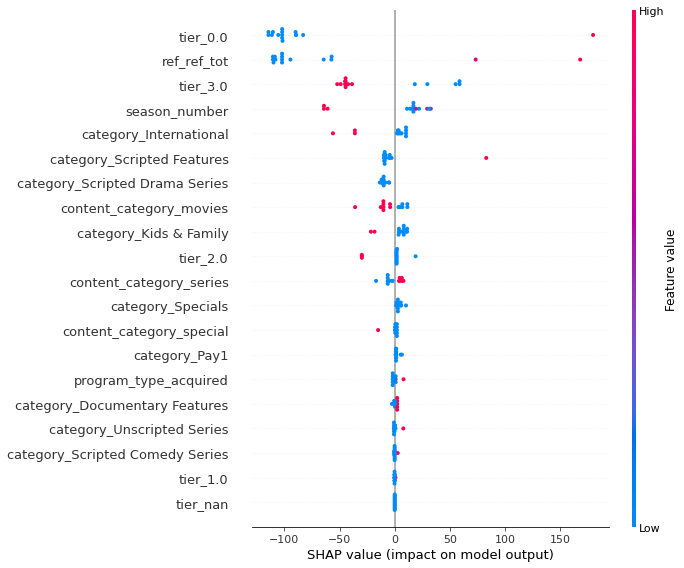

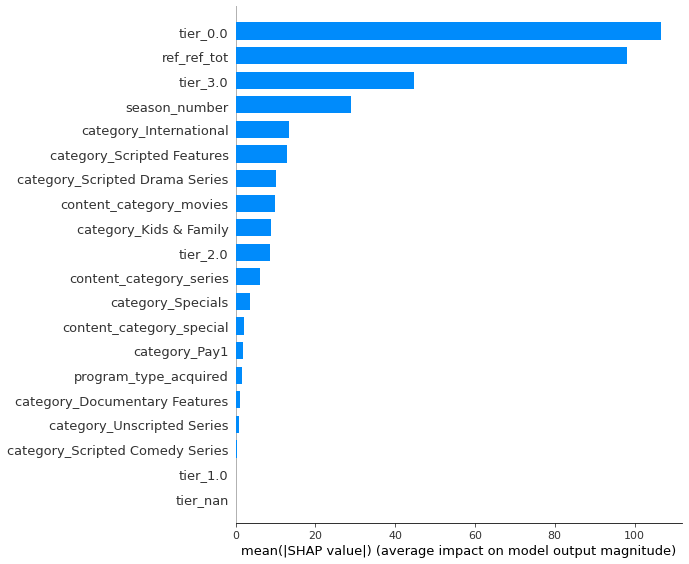

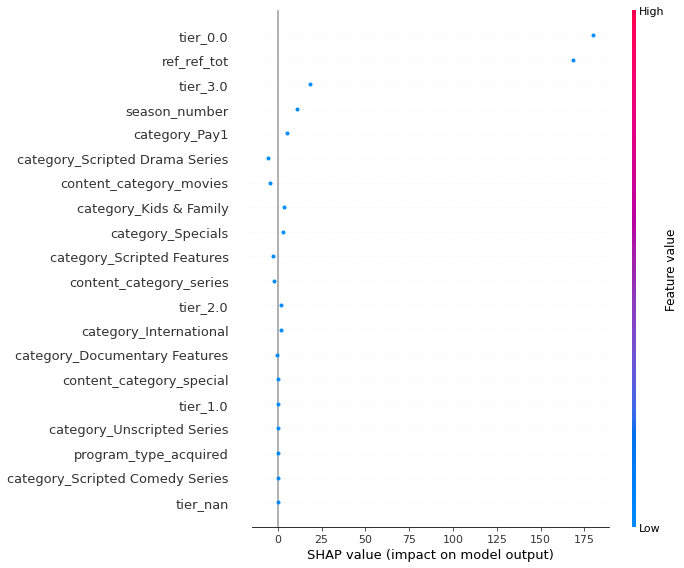

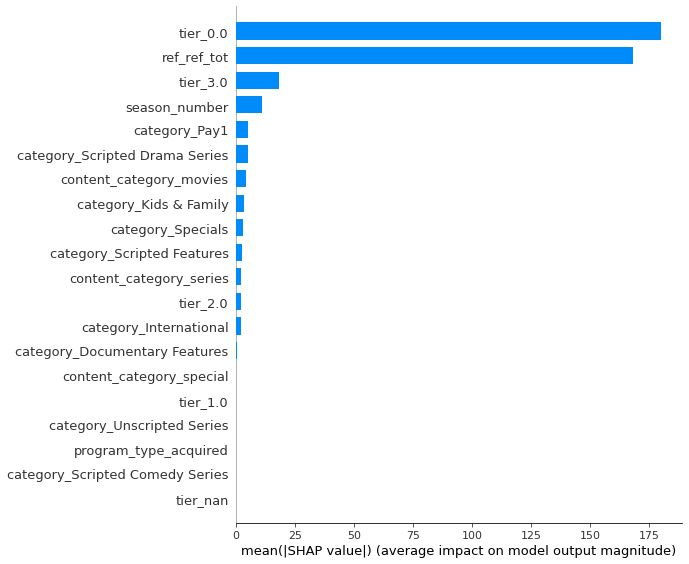

,category,start_year,title_name,tier,season_number,title_id,content_category,ref_ref_tot,first_views,program_type,first_views_log_dev_b,first_views_dev_b
3,Popcorn,2021,Godzilla vs. Kong,0,0,GYFEzmwNES16GkQEAAAAC,movies,164.0,2017162,acquired,820.705078,2.291026e+06
10,Scripted Features,2021,Zack Snyder's Justice League,1,0,GYDAnZgCFQ8IJpQEAAAAN,movies,69.0,1154956,original,595.678040,3.934200e+05
28,Documentary Features,2021,Tina,2,0,GYB2e7gq3xivCIgEAAAAb,movies,0.0,31807,original,338.881989,2.916202e+04
66,Docu-Series,2021,Q: Into the Storm,2,1,GYDk9Ig48c5i6hgEAAAA7,series,0.0,32222,original,381.158752,4.784024e+04
300,Scripted Comedy Series,2021,Genera+ion,2,1,GYCb8twFvgMNNUAEAAAA1,series,0.0,16736,original,381.158752,4.784024e+04
328,Documentary Features,2021,Covid Diaries NYC,3,0,GYBlp3g0gpJmNkAEAAAAC,movies,0.0,1560,original,200.213226,4.142611e+03
337,Documentary Features,2021,Persona: The Dark Truth Behind Personality Tests,3,0,GYC1puQhu1cLCwgEAAAA0,movies,0.0,7850,original,200.213226,4.142611e+03
343,Documentary Features,2021,The Day Sports Stood Still,3,0,GYB3A4QcDM8LDAgEAAABX,movies,0.0,1362,original,200.213226,4.142611e+03
344,Documentary Features,2021,The Last Cruise,3,0,GYEJfggAmqTO8jwEAAAAC,movies,0.0,7333,original,200.213226,4.142611e+03
361,International,2021,The Garden of Evening Mists,3,0,GYEqQ7wi3xJ2evQEAAAAI,movies,0.0,153,acquired,84.204514,3.614978e+02


In [566]:
import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]

## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_ref_tot',
]


df_pred_list = []
for date_pred in ['2021-03-01']:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    df_train_in_tierp = df_train_in[(df_train_in.category=='Popcorn')].sample(target_count, replace=True)
    df_train_in_tier0 = df_train_in[(df_train_in.tier!=3) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
    df_train_in_tier3 = df_train_in[df_train_in.tier==3]
    df_train_in = pd.concat([df_train_in_tierp, df_train_in_tier0, df_train_in_tier3], axis=0)

    display(df_train_in[df_train_in['category']=='Popcorn'])
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)
#         display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)

ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains('Godzilla')], model, ohe, features_cat + features_cont_dev)
shap.force_plot(ev, shap_values, x_ohe)
display(df_pred)

In [434]:
df[df.category=='Popcorn'].sort_values(by='effective_start_date')

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,83.0,6.0,1.0,89.0
46,1,movies,Popcorn,The Little Things,GYA79hQZbUsI3gQEAAAB0,0,acquired,2021-01-29,635584,2.130,2021,1,2021-01,1,13.362300,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,1,movies,Popcorn,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,0,acquired,2021-02-12,319734,2.091,2021,2,2021-02,1,12.675245,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1,movies,Popcorn,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,0,acquired,2021-02-26,595699,1.684,2021,2,2021-02,1,13.297491,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,Godzilla vs. Kong,tt5034838,"[""Action"",""Sci-Fi"",""Thriller""]",movie,3.0,2.0,0.0,146.0,18.0,5.0,164.0
5,0,movies,Popcorn,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,0,acquired,2021-04-23,1074951,1.834,2021,4,2021-04,2,13.887786,Mortal Kombat,tt0293429,"[""Action"",""Adventure"",""Fantasy"",""Sci-Fi"",""Thri...",movie,0.0,1.0,1.0,176.0,62.0,2.0,238.0
48,1,movies,Popcorn,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,0,acquired,2021-05-14,153249,1.661,2021,5,2021-05,2,11.939819,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,1,movies,Popcorn,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,0,acquired,2021-06-04,571005,1.864,2021,6,2021-06,2,13.255153,The Conjuring: The Devil Made Me Do It,tt7069210,"[""Horror"",""Mystery"",""Thriller""]",movie,2.0,0.0,0.0,81.0,5.0,2.0,86.0
42,1,movies,Popcorn,In The Heights,GYK0x7gXCza4OwwEAAADl,0,acquired,2021-06-10,195239,2.383,2021,6,2021-06,2,12.181980,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
df_train_in[(df_train_in.content_category=='movies') & (df_train_in.category!='Popcorn')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,tier_new
0,1,movies,Pay1,Tenet,GYEq4eApHYpA4cwEAAAAC,0,acquired,2021-05-02,43052,2.502,2021,5,2021-05,2,10.670164,1
1,1,movies,Pay1,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2021-05-13,70732,0.000,2021,5,2021-05,2,11.166653,1
6,1,movies,Scripted Features,Roald Dahl’s The Witches,GX5A8JQnSPQ2QFgEAAAAC,0,original,2020-10-22,524524,1.737,2020,10,2020-10,4,13.170246,1
7,1,movies,Scripted Features,Zack Snyder's Justice League,GYDAnZgCFQ8IJpQEAAAAN,0,original,2021-03-18,1154956,4.036,2021,3,2021-03,1,13.959573,1
22,2,movies,Documentary Features,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,original,2020-12-13,49718,1.846,2020,12,2020-12,4,10.814122,2
23,2,movies,Documentary Features,Tina,GYB2e7gq3xivCIgEAAAAb,0,original,2021-03-28,31807,1.962,2021,3,2021-03,1,10.367442,2
24,2,movies,Pay1,Ad Astra,GXo-RygZTqQwlRQEAAAAE,0,acquired,2020-06-07,53772,2.053,2020,6,2020-06,2,10.892508,2
25,2,movies,Pay1,Birds of Prey: Harley Quinn,GXtq0PQyT7MPCwgEAAAaq,0,acquired,2020-08-16,81001,1.814,2020,8,2020-08,3,11.302217,2
26,2,movies,Pay1,Dolittle,GX1oycwoNEsMslAEAAAAI,0,acquired,2020-11-15,37655,1.691,2020,11,2020-11,4,10.536221,2
27,2,movies,Pay1,Ford v Ferrari,GXpTQQAAyyAwlRQEAABgA,0,acquired,2020-06-21,65753,2.548,2020,6,2020-06,2,11.093661,2


In [173]:
df_train_in[(df_train_in.category=='Popcorn')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,tier_new
3,1,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,0
4,1,movies,Popcorn,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,0,acquired,2021-04-23,1074951,1.834,2021,4,2021-04,2,13.887786,0
5,1,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,0
36,2,movies,Popcorn,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,0,acquired,2021-02-12,319734,2.091,2021,2,2021-02,1,12.675245,1
38,2,movies,Popcorn,The Little Things,GYA79hQZbUsI3gQEAAAB0,0,acquired,2021-01-29,635584,2.130,2021,1,2021-01,1,13.362300,1
39,2,movies,Popcorn,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,0,acquired,2021-05-14,153249,1.661,2021,5,2021-05,2,11.939819,1
40,2,movies,Popcorn,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,0,acquired,2021-02-26,595699,1.684,2021,2,2021-02,1,13.297491,1


In [196]:
df_pred['diff'] = (df_pred['first_views_dev']-df_pred['first_views']).abs()
df_pred.sort_values(by='diff', ascending=False)

,title_name,title_id,start_year,tier_new,content_category,program_type,category,season_number,first_views,first_views_dev,diff
37,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021,1,movies,acquired,Popcorn,0,571005,243620.062500,327384.937500
35,In The Heights,GYK0x7gXCza4OwwEAAADl,2021,1,movies,acquired,Popcorn,0,195239,243620.062500,48381.062500
44,No Sudden Move,GYMzEGg049ruJvQEAAAAW,2021,2,movies,acquired,Scripted Features,0,49858,26571.292969,23286.707031
29,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,2021,2,movies,acquired,Pay1,0,10683,28035.773438,17352.773438
34,The Little Things,GYA79hQZbUsI3gQEAAAB0,2021,2,movies,acquired,Pay1,0,38699,28035.773438,10663.226562
142,Fatale,GYHmDAQRp2grCFgEAAAAC,2021,3,movies,acquired,Pay1,0,14697,5685.003418,9011.996582
73,Tom & Jerry in New York,GYMDm0AJXAH0LrgEAAAAF,2021,2,series,original,Kids & Family,1,5113,10089.482422,4976.482422
246,All That Glitters,GYNHTDQuvpMLCewEAAAAG,2021,3,series,original,Unscripted Series,1,1609,5323.430176,3714.430176
147,Kajillionaire,GYIHBbgg_NZ2TjQEAAADx,2021,3,movies,acquired,Pay1,0,2456,5685.003418,3229.003418
133,Juan Luis Guerra 4.40: Entre Mar y Palmeras,GYJ1S5Qt5TG2gdAEAAABv,2021,3,movies,original,International,0,2695,153.333191,2541.666809
